In [0]:

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

In [0]:
# !ls '/content/drive/My Drive/AV_data/WNS_Analytics_Wizard_24082019/'

In [0]:
# !unzip -q '/content/drive/My Drive/AV_data/WNS_Analytics_Wizard_24082019/sample_submission_IPsBlCT.zip'

In [0]:
# !unzip -q '/content/drive/My Drive/AV_data/WNS_Analytics_Wizard_24082019/test.zip'

In [0]:
# !unzip -q '/content/drive/My Drive/AV_data/WNS_Analytics_Wizard_24082019/train.zip'

In [7]:
!ls

adc.json		   avg_lgb_4_lgb_6.csv	       __MACOSX
avg_4.csv		   avg_lgb_6.csv	       sample_data
avg_4_weigths_1.csv	   avg_lgb_cat.csv	       sample_submission.csv
avg_lgb_4.csv		   avg_lgb_cat_xgb_auto_4.csv  test.csv
avg_lgb_4_lgb_6_7030.csv   drive		       train.csv
avg_lgb_4_lgb_6_again.csv  item_data.csv	       view_log.csv


### Load Packages

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import mode
from sklearn import metrics, preprocessing, model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from collections import defaultdict, Counter
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


import string
from imblearn.over_sampling import SMOTE, ADASYN

%matplotlib inline

pd.options.display.max_columns = 100
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### Read the datasets

In [0]:
train_df = pd.read_csv('train.csv')

In [10]:
train_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
impression_id      237609 non-null object
impression_time    237609 non-null object
user_id            237609 non-null int64
app_code           237609 non-null int64
os_version         237609 non-null object
is_4G              237609 non-null int64
is_click           237609 non-null int64
dtypes: int64(4), object(3)
memory usage: 12.7+ MB


In [12]:
train_df.shape

(237609, 7)


The train data has 7 variables and 237609 observations.

In [13]:

train_df.groupby('is_click')['impression_id'].count()

is_click
0    226747
1     10862
Name: impression_id, dtype: int64

In [14]:

train_df['is_click'].value_counts(normalize=True)

0    0.954286
1    0.045714
Name: is_click, dtype: float64

We have imbalance target class. We need to use some upsampling techniques

In [15]:
print(f'Number of samples in train: {train_df.shape[0]}')
print(f'Number of columns in train: {train_df.shape[1]}')
for col in train_df.columns:
    if train_df[col].isnull().any():
        print(col, train_df[col].isnull().sum())

Number of samples in train: 237609
Number of columns in train: 7


In [16]:
train_df.dtypes

impression_id      object
impression_time    object
user_id             int64
app_code            int64
os_version         object
is_4G               int64
is_click            int64
dtype: object

### Missing Value Analysis

In [17]:
missing_data = (((train_df.isnull().sum())*100)/len(train_df))
missing_data

impression_id      0.0
impression_time    0.0
user_id            0.0
app_code           0.0
os_version         0.0
is_4G              0.0
is_click           0.0
dtype: float64

#### Read item_data

In [0]:
item_data_df = pd.read_csv('item_data.csv')

In [19]:
item_data_df.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [20]:
item_data_df.isnull().sum()

item_id         0
item_price      0
category_1      0
category_2      0
category_3      0
product_type    0
dtype: int64

In [21]:
item_data_df.shape

(132761, 6)

#### View Log data

In [0]:
view_log_df = pd.read_csv('view_log.csv')

In [23]:
view_log_df.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [24]:
view_log_df.isnull().sum()

server_time    0
device_type    0
session_id     0
user_id        0
item_id        0
dtype: int64

In [25]:
view_log_df.shape

(3118622, 5)

### Join the datasets View Log and Item Data

In [0]:
#Join the train data and quality and process based on the key timestamp
item_view_log_df = pd.merge(view_log_df, item_data_df, on='item_id', how='left')

In [27]:
item_view_log_df.shape

(3118622, 10)

In [0]:
item_view_log_df.drop_duplicates(inplace=True)

In [29]:
item_view_log_df.shape

(3017496, 10)

In [30]:
item_view_log_df.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type
0,2018-10-15 08:58:00,android,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0
1,2018-10-15 08:58:00,android,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0
2,2018-10-15 08:58:00,android,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0
3,2018-10-15 08:58:00,android,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0
4,2018-10-15 08:58:00,android,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0


In [31]:
item_view_log_df[item_view_log_df['user_id'] ==0].head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type
163910,2018-10-18 14:27:00,android,268465,0,44459,3776.0,14.0,29.0,199.0,7363.0
164584,2018-10-18 14:43:00,android,268465,0,44459,3776.0,14.0,29.0,199.0,7363.0
164700,2018-10-18 14:46:00,android,268465,0,44459,3776.0,14.0,29.0,199.0,7363.0
164774,2018-10-18 14:47:00,android,268465,0,44459,3776.0,14.0,29.0,199.0,7363.0
338978,2018-10-22 09:48:00,android,295495,0,40228,332.0,7.0,24.0,126.0,8351.0


In [32]:
item_view_log_df.dtypes

server_time      object
device_type      object
session_id        int64
user_id           int64
item_id           int64
item_price      float64
category_1      float64
category_2      float64
category_3      float64
product_type    float64
dtype: object

In [33]:
cols = ['device_type']
for col in cols:
    if item_view_log_df[col].dtype==object:
        print(col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(item_view_log_df[col].values.astype('str')))
        item_view_log_df[col] = lbl.transform(list(item_view_log_df[col].values.astype('str')))        

device_type


In [0]:
item_view_log_df['server_time'] = pd.to_datetime(item_view_log_df['server_time'])

In [0]:
item_view_log_df["log_Year"] = item_view_log_df["server_time"].dt.year

item_view_log_df["log_Month"] = item_view_log_df["server_time"].dt.month

item_view_log_df["log_Day"] = item_view_log_df["server_time"].dt.day

item_view_log_df["log_WeekDay"] = item_view_log_df["server_time"].dt.weekday

item_view_log_df["log_time"] = item_view_log_df["server_time"].dt.time

item_view_log_df[['log_h','log_m','log_s']] = item_view_log_df['log_time'].astype(str).str.split(':', expand=True).astype(int)

In [36]:
item_view_log_df.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type,log_Year,log_Month,log_Day,log_WeekDay,log_time,log_h,log_m,log_s
0,2018-10-15 08:58:00,0,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0,2018,10,15,0,08:58:00,8,58,0
1,2018-10-15 08:58:00,0,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0,2018,10,15,0,08:58:00,8,58,0
2,2018-10-15 08:58:00,0,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0,2018,10,15,0,08:58:00,8,58,0
3,2018-10-15 08:58:00,0,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0,2018,10,15,0,08:58:00,8,58,0
4,2018-10-15 08:58:00,0,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0,2018,10,15,0,08:58:00,8,58,0


In [37]:
item_view_log_df['log_Year'].value_counts()

2018    3017496
Name: log_Year, dtype: int64

In [38]:
item_view_log_df['log_Month'].value_counts()

11    1551926
10     794575
12     670995
Name: log_Month, dtype: int64

In [39]:
item_view_log_df['log_Day'].value_counts()

4     125430
11    123341
5     120064
10    113630
17    111926
3     111568
2     110505
21    109722
6     109376
9     108360
18    106871
20    106490
1     105778
23    105643
16    102450
7     101995
8     101894
25    100561
22    100318
19     99246
30     95843
24     94406
15     92966
29     90666
27     86423
26     83890
28     76849
14     66901
12     56976
31     49460
13     47948
Name: log_Day, dtype: int64

In [0]:
# ### Convert all the variables into category
# item_view_log_df.session_id=dftest.session_id.astype(np.object)
# item_view_log_df.user_id=dftest.user_id.astype(np.object)
# item_view_log_df.item_id=dftest.item_id.astype(np.object)

# item_view_log_df.category_1=dftest.category_1.astype(np.object)
# item_view_log_df.category_2=dftest.category_2.astype(np.object)
# item_view_log_df.category_3=dftest.category_3.astype(np.object)

# item_view_log_df.product_type=dftest.product_type.astype(np.object)

### Grouping the viewed log data using and extracting features

In [41]:
item_view_log_df['device_type'].value_counts()

0    3016689
1        783
2         24
Name: device_type, dtype: int64

In [42]:
item_view_log_df['product_type'].value_counts().head()

2874.0     96611
5036.0     30007
5622.0     29493
10412.0    29319
7455.0     26324
Name: product_type, dtype: int64

In [0]:
days_active = item_view_log_df.reset_index().groupby(['user_id'])['server_time'].agg(lambda x: (x.max() - x.min()).days if (x.max() - x.min()).days !=0 else 1)
unique_days_active = item_view_log_df.reset_index().groupby(['user_id'])['server_time'].agg(lambda x: len(np.unique(x.dt.dayofyear)))
user_time_features = days_active.reset_index().merge(unique_days_active.reset_index(),on='user_id',how = 'left')
user_time_features.columns = ['user_id','log_days_active','log_unique_days_active']


In [44]:
user_time_features.head()

,user_id,log_days_active,log_unique_days_active
0,0,50,11
1,1,34,3
2,2,54,22
3,3,1,1
4,4,1,1


In [45]:
user_time_features.shape

(89157, 3)

In [46]:
user_time_features['user_id'].nunique()

89157

In [47]:
item_view_log_df.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type,log_Year,log_Month,log_Day,log_WeekDay,log_time,log_h,log_m,log_s
0,2018-10-15 08:58:00,0,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0,2018,10,15,0,08:58:00,8,58,0
1,2018-10-15 08:58:00,0,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0,2018,10,15,0,08:58:00,8,58,0
2,2018-10-15 08:58:00,0,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0,2018,10,15,0,08:58:00,8,58,0
3,2018-10-15 08:58:00,0,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0,2018,10,15,0,08:58:00,8,58,0
4,2018-10-15 08:58:00,0,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0,2018,10,15,0,08:58:00,8,58,0


In [48]:
item_view_log_df[item_view_log_df['session_id'] == 112333]

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type,log_Year,log_Month,log_Day,log_WeekDay,log_time,log_h,log_m,log_s
0,2018-10-15 08:58:00,0,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0,2018,10,15,0,08:58:00,8,58,0
41,2018-10-15 08:59:00,0,112333,4557,132775,480.0,4.0,1.0,111.0,9362.0,2018,10,15,0,08:59:00,8,59,0
43,2018-10-15 08:59:00,0,112333,4557,100092,377.0,0.0,6.0,145.0,10036.0,2018,10,15,0,08:59:00,8,59,0
89,2018-10-15 09:01:00,0,112333,4557,115470,8019.0,13.0,78.0,134.0,2874.0,2018,10,15,0,09:01:00,9,1,0
138,2018-10-15 09:03:00,0,112333,4557,35370,480.0,0.0,6.0,50.0,1457.0,2018,10,15,0,09:03:00,9,3,0


In [49]:
item_view_log_df['session_id'].value_counts().head()

368760    173
639379    148
3831      136
482535    128
607672    126
Name: session_id, dtype: int64

In [50]:
item_view_log_df['category_1'].nunique()

17

In [51]:
item_view_log_df['category_2'].nunique()

79

In [52]:
item_view_log_df['category_3'].nunique()

335

In [53]:
item_view_log_df['item_id'].nunique() 

126708

In [54]:
item_view_log_df['product_type'].nunique() 

7846

In [55]:
item_view_log_df.columns

Index(['server_time', 'device_type', 'session_id', 'user_id', 'item_id',
       'item_price', 'category_1', 'category_2', 'category_3', 'product_type',
       'log_Year', 'log_Month', 'log_Day', 'log_WeekDay', 'log_time', 'log_h',
       'log_m', 'log_s'],
      dtype='object')

In [56]:
item_view_log_df.dtypes

server_time     datetime64[ns]
device_type              int64
session_id               int64
user_id                  int64
item_id                  int64
item_price             float64
category_1             float64
category_2             float64
category_3             float64
product_type           float64
log_Year                 int64
log_Month                int64
log_Day                  int64
log_WeekDay              int64
log_time                object
log_h                    int64
log_m                    int64
log_s                    int64
dtype: object

In [57]:
log_Month_df = pd.pivot_table(item_view_log_df, values="session_id", index="user_id", columns="log_Month", aggfunc="count", fill_value=0).reset_index()
print(log_Month_df.columns)

log_Month_df.columns = ["user_id"] + ["log_Month_"+str(i) for i in range(10,13)]



Index(['user_id', 10, 11, 12], dtype='object', name='log_Month')


In [58]:
log_WeekDay_df = pd.pivot_table(item_view_log_df, values="session_id", index="user_id", columns="log_WeekDay", aggfunc="count", fill_value=0).reset_index()
print(log_WeekDay_df.columns)


log_WeekDay_df.columns = ["user_id"] + ["log_WeekDay_"+str(i) for i in range(0,7)]



Index(['user_id', 0, 1, 2, 3, 4, 5, 6], dtype='object', name='log_WeekDay')


In [59]:
log_WeekDay_df.head()

,user_id,log_WeekDay_0,log_WeekDay_1,log_WeekDay_2,log_WeekDay_3,log_WeekDay_4,log_WeekDay_5,log_WeekDay_6
0,0,2,2,7,6,3,0,17
1,1,1,0,0,0,0,0,7
2,2,30,26,29,31,9,0,38
3,3,0,0,0,0,8,0,0
4,4,0,0,0,0,2,0,0


In [60]:
log_WeekDay_df.shape

(89157, 8)

In [61]:
item_view_log_df[(item_view_log_df['user_id'] == 4557)].shape

(38, 18)

In [62]:
item_view_log_df[(item_view_log_df['user_id'] == 4557) & (item_view_log_df['category_1'] == 16.0)].head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type,log_Year,log_Month,log_Day,log_WeekDay,log_time,log_h,log_m,log_s
0,2018-10-15 08:58:00,0,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0,2018,10,15,0,08:58:00,8,58,0
254633,2018-10-20 13:56:00,0,1065742,4557,109289,4025.0,16.0,56.0,42.0,7962.0,2018,10,20,5,13:56:00,13,56,0
552661,2018-10-26 15:54:00,0,808109,4557,1126,1209.0,16.0,68.0,40.0,7141.0,2018,10,26,4,15:54:00,15,54,0
2086917,2018-11-23 15:54:00,0,412477,4557,36849,3776.0,16.0,56.0,17.0,9227.0,2018,11,23,4,15:54:00,15,54,0
2261005,2018-11-26 23:40:00,0,1032995,4557,44364,5690.0,16.0,68.0,326.0,7820.0,2018,11,26,0,23:40:00,23,40,0


In [63]:
item_view_log_df['category_1'].min(), item_view_log_df['category_1'].max()

(0.0, 17.0)

In [64]:
category_1_df = pd.pivot_table(item_view_log_df, values="item_id", index="user_id", columns="category_1", aggfunc="count", fill_value=0).reset_index()
print(category_1_df.columns)

category_1_df.columns = ["user_id"] + ["cat_1_"+str(i) for i in range(0,17)]


Index(['user_id',       0.0,       1.0,       2.0,       4.0,       5.0,
             6.0,       7.0,       8.0,       9.0,      10.0,      11.0,
            12.0,      13.0,      14.0,      15.0,      16.0,      17.0],
      dtype='object', name='category_1')


In [65]:
category_1_df.head()

,user_id,cat_1_0,cat_1_1,cat_1_2,cat_1_3,cat_1_4,cat_1_5,cat_1_6,cat_1_7,cat_1_8,cat_1_9,cat_1_10,cat_1_11,cat_1_12,cat_1_13,cat_1_14,cat_1_15,cat_1_16
0,0,0,6,0,1,0,5,7,0,0,0,0,0,2,7,1,1,7
1,1,1,0,0,0,0,0,1,1,0,0,2,1,1,0,1,0,0
2,2,1,31,0,6,0,1,10,8,19,8,11,11,8,11,4,8,26
3,3,2,3,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0
4,4,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [66]:
category_1_df.shape

(89152, 18)

In [67]:
item_view_log_df['category_2'].min(), item_view_log_df['category_2'].max()

(0.0, 79.0)

In [0]:
category_2_df = pd.pivot_table(item_view_log_df, values="item_id", index="user_id", columns="category_2", aggfunc="count", fill_value=0).reset_index()
category_2_df.columns = ["user_id"] + ["cat_2_"+str(i) for i in range(0,79)]


In [69]:
category_2_df.head()

,user_id,cat_2_0,cat_2_1,cat_2_2,cat_2_3,cat_2_4,cat_2_5,cat_2_6,cat_2_7,cat_2_8,cat_2_9,cat_2_10,cat_2_11,cat_2_12,cat_2_13,cat_2_14,cat_2_15,cat_2_16,cat_2_17,cat_2_18,cat_2_19,cat_2_20,cat_2_21,cat_2_22,cat_2_23,cat_2_24,cat_2_25,cat_2_26,cat_2_27,cat_2_28,cat_2_29,cat_2_30,cat_2_31,cat_2_32,cat_2_33,cat_2_34,cat_2_35,cat_2_36,cat_2_37,cat_2_38,cat_2_39,cat_2_40,cat_2_41,cat_2_42,cat_2_43,cat_2_44,cat_2_45,cat_2_46,cat_2_47,cat_2_48,cat_2_49,cat_2_50,cat_2_51,cat_2_52,cat_2_53,cat_2_54,cat_2_55,cat_2_56,cat_2_57,cat_2_58,cat_2_59,cat_2_60,cat_2_61,cat_2_62,cat_2_63,cat_2_64,cat_2_65,cat_2_66,cat_2_67,cat_2_68,cat_2_69,cat_2_70,cat_2_71,cat_2_72,cat_2_73,cat_2_74,cat_2_75,cat_2_76,cat_2_77,cat_2_78
0,0,0,0,0,0,0,0,0,2,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,4,0,0,4,0,0,2,0,0,4,0,0,1,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,2,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0
2,2,0,1,0,4,3,0,0,3,8,3,4,0,5,3,0,0,0,2,1,0,1,3,0,3,1,0,9,0,7,3,0,2,2,0,0,1,4,2,6,2,3,11,6,5,1,2,1,0,0,0,6,0,0,0,3,0,7,5,0,0,6,2,2,4,0,3,0,2,0,2,0,0,0,3,0,3,1,2,0
3,3,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [70]:
item_view_log_df['category_3'].min(), item_view_log_df['category_3'].max()

(0.0, 341.0)

In [71]:
item_view_log_df['product_type'].min(), item_view_log_df['product_type'].max()

(0.0, 10583.0)

In [72]:
bins = [0,7,15,22,31]

group_names = [1, 2, 3, 4]
item_view_log_df['Month_wk_grp'] = pd.cut(item_view_log_df['log_Day'], bins, labels=group_names)
item_view_log_df.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type,log_Year,log_Month,log_Day,log_WeekDay,log_time,log_h,log_m,log_s,Month_wk_grp
0,2018-10-15 08:58:00,0,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0,2018,10,15,0,08:58:00,8,58,0,2
1,2018-10-15 08:58:00,0,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0,2018,10,15,0,08:58:00,8,58,0,2
2,2018-10-15 08:58:00,0,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0,2018,10,15,0,08:58:00,8,58,0,2
3,2018-10-15 08:58:00,0,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0,2018,10,15,0,08:58:00,8,58,0,2
4,2018-10-15 08:58:00,0,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0,2018,10,15,0,08:58:00,8,58,0,2


In [0]:
item_view_log_df['Month_wk_grp'] = pd.to_numeric(item_view_log_df['Month_wk_grp'])

In [0]:
log_Month_wk_grp_df = pd.pivot_table(item_view_log_df, index="user_id", columns="Month_wk_grp", values="session_id", aggfunc="count", fill_value=0).reset_index()
log_Month_wk_grp_df.columns = ["user_id"] + ["log_Month_wk_grp_"+str(i) for i in range(1,5)]



In [75]:
log_Month_wk_grp_df.head()

,user_id,log_Month_wk_grp_1,log_Month_wk_grp_2,log_Month_wk_grp_3,log_Month_wk_grp_4
0,0,10,19,5,3
1,1,2,6,0,0
2,2,39,9,75,40
3,3,0,0,8,0
4,4,2,0,0,0


#### Read test data 

In [0]:
test_df = pd.read_csv('test.csv')

In [77]:
test_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1


In [78]:
test_df.shape

(90675, 6)

In [79]:
test_df['app_code'].value_counts().head()

207    14412
386    14293
190     6789
127     3208
296     3181
Name: app_code, dtype: int64

In [0]:
from matplotlib_venn import venn2, venn2_circles

In [0]:
def get_venn(axarr, feature):
    axarr[0,0].set_title(f'Overlap between {feature} in train and test')
    venn2([set(train_df[feature].values), set(test_df[feature].values)], set_labels = ('train','test'), ax=axarr[0,0])
    
    axarr[0,1].set_title(f'Overlap between {feature} in train and hist')
    venn2([set(train_df[feature].values), set(item_view_log_df[feature].values)], set_labels = ('train','hist'), ax=axarr[0,1])
    
    axarr[1,0].set_title(f'Overlap between {feature} in test and hist')
    venn2([set(test_df[feature].values), set(item_view_log_df[feature].values)], set_labels = ('test','hist'), ax=axarr[1,0])
    
    axarr[1,1].set_title(f'Overlap between {feature} in train and test')
    venn2([set(train_df[feature].values), set(test_df[feature].values)], set_labels = ('train','test'), ax=axarr[1,1])

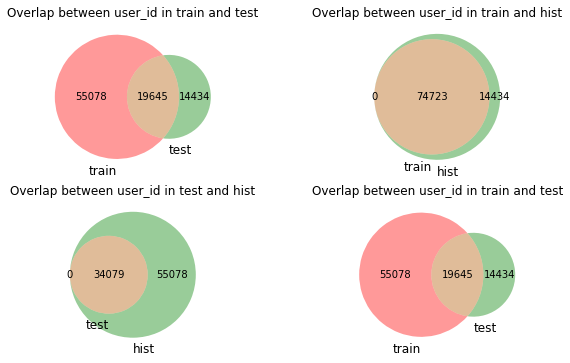

In [82]:
fig, axarr = plt.subplots(2,2, figsize=(10,6))
get_venn(axarr, 'user_id')

#### Join Train and LogView data

In [83]:
item_view_log_df.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type,log_Year,log_Month,log_Day,log_WeekDay,log_time,log_h,log_m,log_s,Month_wk_grp
0,2018-10-15 08:58:00,0,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0,2018,10,15,0,08:58:00,8,58,0,2
1,2018-10-15 08:58:00,0,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0,2018,10,15,0,08:58:00,8,58,0,2
2,2018-10-15 08:58:00,0,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0,2018,10,15,0,08:58:00,8,58,0,2
3,2018-10-15 08:58:00,0,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0,2018,10,15,0,08:58:00,8,58,0,2
4,2018-10-15 08:58:00,0,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0,2018,10,15,0,08:58:00,8,58,0,2


In [84]:
train_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [85]:
train_df[train_df['user_id'] == 87862]

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
616,621bf66ddb7c962aa0d22ac97d69b793,2018-11-15 00:19:00,87862,422,old,0,0
5936,ab394288aed46588bdc90bf4b541ec0d,2018-11-16 17:29:00,87862,422,old,0,0


In [86]:
train_df['os_version'].value_counts()

latest          129216
intermediate     55543
old              52850
Name: os_version, dtype: int64

In [0]:
# * join the datasets
train_df['is_train']  = 1
test_df['is_click'] = -99
test_df['is_train'] = 0

In [0]:
full_df = train_df.append(test_df)

In [89]:
full_df.dtypes

impression_id      object
impression_time    object
user_id             int64
app_code            int64
os_version         object
is_4G               int64
is_click            int64
is_train            int64
dtype: object

In [0]:
full_df['impression_time'] = pd.to_datetime(full_df['impression_time'])

In [91]:
full_df.dtypes

impression_id              object
impression_time    datetime64[ns]
user_id                     int64
app_code                    int64
os_version                 object
is_4G                       int64
is_click                    int64
is_train                    int64
dtype: object

In [0]:
full_df["Year"] = full_df["impression_time"].dt.year

full_df["Month"] = full_df["impression_time"].dt.month

full_df["Day"] = full_df["impression_time"].dt.day

full_df["WeekDay"] = full_df["impression_time"].dt.weekday

full_df["time"] = full_df["impression_time"].dt.time

full_df[['h','m','s']] = full_df['time'].astype(str).str.split(':', expand=True).astype(int)

In [93]:
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,2018,11,15,3,00:00:00,0,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,2018,11,15,3,00:01:00,0,1,0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,1,2018,11,15,3,00:02:00,0,2,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,1,2018,11,15,3,00:02:00,0,2,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,1,2018,11,15,3,00:02:00,0,2,0


In [94]:
full_df.dtypes

impression_id              object
impression_time    datetime64[ns]
user_id                     int64
app_code                    int64
os_version                 object
is_4G                       int64
is_click                    int64
is_train                    int64
Year                        int64
Month                       int64
Day                         int64
WeekDay                     int64
time                       object
h                           int64
m                           int64
s                           int64
dtype: object

In [0]:
### pivot
gdf = pd.pivot_table(full_df, index="user_id", columns="Year", values="impression_id", aggfunc="count", fill_value=0).reset_index()
full_df = pd.merge(full_df, gdf, on="user_id", how="left")


In [96]:
full_df['Year'].value_counts()

2018    328284
Name: Year, dtype: int64

In [97]:
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,2018,11,15,3,00:00:00,0,0,0,3
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,2018,11,15,3,00:01:00,0,1,0,61
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,1,2018,11,15,3,00:02:00,0,2,0,13
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,1,2018,11,15,3,00:02:00,0,2,0,4
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,1,2018,11,15,3,00:02:00,0,2,0,16


In [0]:
gdf = pd.pivot_table(full_df, index="user_id", columns="Month", values="impression_id", aggfunc="count", fill_value=0).reset_index()
gdf.columns = ["user_id"] + ["Month_"+str(i) for i in range(11,13)]
full_df = pd.merge(full_df, gdf, on="user_id", how="left")


In [99]:
full_df['app_code'].nunique()

522

In [100]:
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,2018,11,15,3,00:00:00,0,0,0,3,3,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,2018,11,15,3,00:01:00,0,1,0,61,29,32
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,1,2018,11,15,3,00:02:00,0,2,0,13,7,6
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,1,2018,11,15,3,00:02:00,0,2,0,4,4,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,1,2018,11,15,3,00:02:00,0,2,0,16,16,0


In [0]:
gdf = pd.pivot_table(full_df, index="user_id", columns="Day", values="impression_id", aggfunc="count", fill_value=0).reset_index()
gdf.columns = ["user_id"] + ["Day_"+str(i) for i in range(1,31)]
full_df = pd.merge(full_df, gdf, on="user_id", how="left")


In [102]:
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,2018,11,15,3,00:00:00,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,2018,11,15,3,00:01:00,0,1,0,61,29,32,2,2,2,2,2,2,2,2,2,2,2,2,0,2,4,4,4,2,2,2,2,2,1,2,2,2,2,0,2,2
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,1,2018,11,15,3,00:02:00,0,2,0,13,7,6,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2,0,0,2,0,0,0,1,0,0,0,0,0,2,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,1,2018,11,15,3,00:02:00,0,2,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,1,2018,11,15,3,00:02:00,0,2,0,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,2,2,2,0,0,2,0,0,0,0,0


In [0]:
### pivot on MOdel and Year
gdf = pd.pivot_table(full_df, index="user_id", columns="WeekDay", values="impression_id", aggfunc="count", fill_value=0).reset_index()
gdf.columns = ["user_id"] + ["WeekDay_"+str(i) for i in range(0,7)]
full_df = pd.merge(full_df, gdf, on="user_id", how="left")


In [104]:
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,WeekDay_0,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,2018,11,15,3,00:00:00,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,2018,11,15,3,00:01:00,0,1,0,61,29,32,2,2,2,2,2,2,2,2,2,2,2,2,0,2,4,4,4,2,2,2,2,2,1,2,2,2,2,0,2,2,10,8,6,8,9,10,10
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,1,2018,11,15,3,00:02:00,0,2,0,13,7,6,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2,0,0,2,0,0,0,1,0,0,0,0,0,2,0,2,0,2,4,3,0,2
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,1,2018,11,15,3,00:02:00,0,2,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,1,2018,11,15,3,00:02:00,0,2,0,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,2,2,2,0,0,2,0,0,0,0,0,0,2,2,4,2,2,4


In [0]:
ad_days_active = full_df.reset_index().groupby(['user_id'])['impression_time'].agg(lambda x: (x.max() - x.min()).days if (x.max() - x.min()).days !=0 else 1)
ad_unique_days_active = full_df.reset_index().groupby(['user_id'])['impression_time'].agg(lambda x: len(np.unique(x.dt.dayofyear)))
ad_user_time_features = ad_days_active.reset_index().merge(ad_unique_days_active.reset_index(),on='user_id',how = 'left')
ad_user_time_features.columns = ['user_id','ad_days_active','ad_unique_days_active']

In [0]:
full_df = pd.merge(full_df, ad_user_time_features, on="user_id", how="left")

In [107]:
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,WeekDay_0,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6,ad_days_active,ad_unique_days_active
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,2018,11,15,3,00:00:00,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,2
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,2018,11,15,3,00:01:00,0,1,0,61,29,32,2,2,2,2,2,2,2,2,2,2,2,2,0,2,4,4,4,2,2,2,2,2,1,2,2,2,2,0,2,2,10,8,6,8,9,10,10,32,31
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,1,2018,11,15,3,00:02:00,0,2,0,13,7,6,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2,0,0,2,0,0,0,1,0,0,0,0,0,2,0,2,0,2,4,3,0,2,31,7
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,1,2018,11,15,3,00:02:00,0,2,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,7,3
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,1,2018,11,15,3,00:02:00,0,2,0,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,2,2,2,0,0,2,0,0,0,0,0,0,2,2,4,2,2,4,10,8


In [0]:
full_df = pd.merge(full_df, user_time_features, on="user_id", how="left")

In [109]:
full_df.tail()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,WeekDay_0,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6,ad_days_active,ad_unique_days_active,log_days_active,log_unique_days_active
328279,14e40cf9f6b71d972a8cbf6836a230c4,2018-12-18 23:56:00,69289,371,latest,0,-99,0,2018,12,18,1,23:56:00,23,56,0,24,10,14,2,2,0,0,2,0,0,0,0,0,0,0,0,0,4,2,2,4,2,2,0,0,0,0,0,0,2,0,0,0,4,6,2,2,0,4,6,33,12,27,8
328280,e473cad398d5de9cb5be83d9a9ca0b97,2018-12-18 23:56:00,28539,151,latest,1,-99,0,2018,12,18,1,23:56:00,23,56,0,9,0,9,0,0,2,1,2,0,0,0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,3,2,2,0,0,0,15,5,45,8
328281,e99817afa73431282bb3ddb6eaff1ff7,2018-12-18 23:57:00,54764,243,old,0,-99,0,2018,12,18,1,23:57:00,23,57,0,12,4,8,0,0,2,0,0,0,0,0,2,0,0,0,2,0,2,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,4,2,0,4,0,0,2,33,6,53,8
328282,70ace7a2908312f7e24a427afefb2a55,2018-12-18 23:59:00,22313,272,latest,1,-99,0,2018,12,18,1,23:59:00,23,59,0,6,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,2,0,4,4,46,9
328283,539145030fb3600d26d6a64130310035,2018-12-18 23:59:00,82078,242,latest,1,-99,0,2018,12,18,1,23:59:00,23,59,0,17,0,17,0,1,0,0,0,0,0,0,0,0,2,0,2,2,1,3,4,2,0,0,0,0,0,0,0,0,0,0,0,0,4,4,0,2,2,1,4,16,8,11,4


In [0]:
full_df = pd.merge(full_df, category_1_df, on="user_id", how="left") 

In [111]:
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,WeekDay_0,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6,ad_days_active,ad_unique_days_active,log_days_active,log_unique_days_active,cat_1_0,cat_1_1,cat_1_2,cat_1_3,cat_1_4,cat_1_5,cat_1_6,cat_1_7,cat_1_8,cat_1_9,cat_1_10,cat_1_11,cat_1_12,cat_1_13,cat_1_14,cat_1_15,cat_1_16
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,2018,11,15,3,00:00:00,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,2018,11,15,3,00:01:00,0,1,0,61,29,32,2,2,2,2,2,2,2,2,2,2,2,2,0,2,4,4,4,2,2,2,2,2,1,2,2,2,2,0,2,2,10,8,6,8,9,10,10,32,31,50,6,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,1,2018,11,15,3,00:02:00,0,2,0,13,7,6,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2,0,0,2,0,0,0,1,0,0,0,0,0,2,0,2,0,2,4,3,0,2,31,7,30,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,1,2018,11,15,3,00:02:00,0,2,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,7,3,11,7,2.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,2.0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,1,2018,11,15,3,00:02:00,0,2,0,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,2,2,2,0,0,2,0,0,0,0,0,0,2,2,4,2,2,4,10,8,54,19,0.0,4.0,0.0,3.0,0.0,1.0,4.0,3.0,7.0,1.0,7.0,3.0,1.0,1.0,1.0,0.0,9.0


In [0]:
full_df = pd.merge(full_df, log_WeekDay_df, on="user_id", how="left") 

In [113]:
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,WeekDay_0,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6,ad_days_active,ad_unique_days_active,log_days_active,log_unique_days_active,cat_1_0,cat_1_1,cat_1_2,cat_1_3,cat_1_4,cat_1_5,cat_1_6,cat_1_7,cat_1_8,cat_1_9,cat_1_10,cat_1_11,cat_1_12,cat_1_13,cat_1_14,cat_1_15,cat_1_16,log_WeekDay_0,log_WeekDay_1,log_WeekDay_2,log_WeekDay_3,log_WeekDay_4,log_WeekDay_5,log_WeekDay_6
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,2018,11,15,3,00:00:00,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,2018,11,15,3,00:01:00,0,1,0,61,29,32,2,2,2,2,2,2,2,2,2,2,2,2,0,2,4,4,4,2,2,2,2,2,1,2,2,2,2,0,2,2,10,8,6,8,9,10,10,32,31,50,6,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5,0,1,2,0,1,3
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,1,2018,11,15,3,00:02:00,0,2,0,13,7,6,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2,0,0,2,0,0,0,1,0,0,0,0,0,2,0,2,0,2,4,3,0,2,31,7,30,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,1,2018,11,15,3,00:02:00,0,2,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,7,3,11,7,2.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,2.0,2,0,9,1,1,4,1
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,1,2018,11,15,3,00:02:00,0,2,0,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,2,2,2,0,0,2,0,0,0,0,0,0,2,2,4,2,2,4,10,8,54,19,0.0,4.0,0.0,3.0,0.0,1.0,4.0,3.0,7.0,1.0,7.0,3.0,1.0,1.0,1.0,0.0,9.0,7,4,9,15,5,2,3


In [0]:
full_df = pd.merge(full_df, log_Month_df, on="user_id", how="left") 

In [0]:
# full_df = pd.merge(full_df, category_2_df, on="user_id", how="left") 

In [116]:
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,WeekDay_0,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6,ad_days_active,ad_unique_days_active,log_days_active,log_unique_days_active,cat_1_0,cat_1_1,cat_1_2,cat_1_3,cat_1_4,cat_1_5,cat_1_6,cat_1_7,cat_1_8,cat_1_9,cat_1_10,cat_1_11,cat_1_12,cat_1_13,cat_1_14,cat_1_15,cat_1_16,log_WeekDay_0,log_WeekDay_1,log_WeekDay_2,log_WeekDay_3,log_WeekDay_4,log_WeekDay_5,log_WeekDay_6,log_Month_10,log_Month_11,log_Month_12
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,2018,11,15,3,00:00:00,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,2018,11,15,3,00:01:00,0,1,0,61,29,32,2,2,2,2,2,2,2,2,2,2,2,2,0,2,4,4,4,2,2,2,2,2,1,2,2,2,2,0,2,2,10,8,6,8,9,10,10,32,31,50,6,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5,0,1,2,0,1,3,7,1,4
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,1,2018,11,15,3,00:02:00,0,2,0,13,7,6,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2,0,0,2,0,0,0,1,0,0,0,0,0,2,0,2,0,2,4,3,0,2,31,7,30,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,1,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,1,2018,11,15,3,00:02:00,0,2,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,7,3,11,7,2.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,2.0,2,0,9,1,1,4,1,0,18,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,1,2018,11,15,3,00:02:00,0,2,0,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,2,2,2,0,0,2,0,0,0,0,0,0,2,2,4,2,2,4,10,8,54,19,0.0,4.0,0.0,3.0,0.0,1.0,4.0,3.0,7.0,1.0,7.0,3.0,1.0,1.0,1.0,0.0,9.0,7,4,9,15,5,2,3,2,21,22


In [0]:
# full_df = pd.merge(full_df, log_Day_df, on="user_id", how="left")   

In [0]:
full_df = pd.merge(full_df, log_Month_wk_grp_df, on="user_id", how="left")  

In [119]:
full_df.shape

(328284, 91)

In [120]:
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,WeekDay_0,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6,ad_days_active,ad_unique_days_active,log_days_active,log_unique_days_active,cat_1_0,cat_1_1,cat_1_2,cat_1_3,cat_1_4,cat_1_5,cat_1_6,cat_1_7,cat_1_8,cat_1_9,cat_1_10,cat_1_11,cat_1_12,cat_1_13,cat_1_14,cat_1_15,cat_1_16,log_WeekDay_0,log_WeekDay_1,log_WeekDay_2,log_WeekDay_3,log_WeekDay_4,log_WeekDay_5,log_WeekDay_6,log_Month_10,log_Month_11,log_Month_12,log_Month_wk_grp_1,log_Month_wk_grp_2,log_Month_wk_grp_3,log_Month_wk_grp_4
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,2018,11,15,3,00:00:00,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,2018,11,15,3,00:01:00,0,1,0,61,29,32,2,2,2,2,2,2,2,2,2,2,2,2,0,2,4,4,4,2,2,2,2,2,1,2,2,2,2,0,2,2,10,8,6,8,9,10,10,32,31,50,6,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5,0,1,2,0,1,3,7,1,4,0,4,4,4
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,1,2018,11,15,3,00:02:00,0,2,0,13,7,6,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2,0,0,2,0,0,0,1,0,0,0,0,0,2,0,2,0,2,4,3,0,2,31,7,30,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,1,1,0,0,0,0,2
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,1,2018,11,15,3,00:02:00,0,2,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,7,3,11,7,2.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,2.0,2,0,9,1,1,4,1,0,18,0,0,11,6,1
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,1,2018,11,15,3,00:02:00,0,2,0,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,2,2,2,0,0,2,0,0,0,0,0,0,2,2,4,2,2,4,10,8,54,19,0.0,4.0,0.0,3.0,0.0,1.0,4.0,3.0,7.0,1.0,7.0,3.0,1.0,1.0,1.0,0.0,9.0,7,4,9,15,5,2,3,2,21,22,20,10,13,2


In [121]:
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,WeekDay_0,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6,ad_days_active,ad_unique_days_active,log_days_active,log_unique_days_active,cat_1_0,cat_1_1,cat_1_2,cat_1_3,cat_1_4,cat_1_5,cat_1_6,cat_1_7,cat_1_8,cat_1_9,cat_1_10,cat_1_11,cat_1_12,cat_1_13,cat_1_14,cat_1_15,cat_1_16,log_WeekDay_0,log_WeekDay_1,log_WeekDay_2,log_WeekDay_3,log_WeekDay_4,log_WeekDay_5,log_WeekDay_6,log_Month_10,log_Month_11,log_Month_12,log_Month_wk_grp_1,log_Month_wk_grp_2,log_Month_wk_grp_3,log_Month_wk_grp_4
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,2018,11,15,3,00:00:00,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,2018,11,15,3,00:01:00,0,1,0,61,29,32,2,2,2,2,2,2,2,2,2,2,2,2,0,2,4,4,4,2,2,2,2,2,1,2,2,2,2,0,2,2,10,8,6,8,9,10,10,32,31,50,6,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5,0,1,2,0,1,3,7,1,4,0,4,4,4
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,1,2018,11,15,3,00:02:00,0,2,0,13,7,6,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2,0,0,2,0,0,0,1,0,0,0,0,0,2,0,2,0,2,4,3,0,2,31,7,30,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,1,1,0,0,0,0,2
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,1,2018,11,15,3,00:02:00,0,2,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,7,3,11,7,2.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,2.0,2,0,9,1,1,4,1,0,18,0,0,11,6,1
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,1,2018,11,15,3,00:02:00,0,2,0,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,2,2,2,0,0,2,0,0,0,0,0,0,2,2,4,2,2,4,10,8,54,19,0.0,4.0,0.0,3.0,0.0,1.0,4.0,3.0,7.0,1.0,7.0,3.0,1.0,1.0,1.0,0.0,9.0,7,4,9,15,5,2,3,2,21,22,20,10,13,2


#### Add the user time features from the item log window

In [122]:
testcount = len(test_df)
count = len(full_df)-testcount
print(count)

237609


In [123]:
full_df.isnull().sum()

impression_id         0
impression_time       0
user_id               0
app_code              0
os_version            0
is_4G                 0
is_click              0
is_train              0
Year                  0
Month                 0
Day                   0
WeekDay               0
time                  0
h                     0
m                     0
s                     0
2018                  0
Month_11              0
Month_12              0
Day_1                 0
Day_2                 0
Day_3                 0
Day_4                 0
Day_5                 0
Day_6                 0
Day_7                 0
Day_8                 0
Day_9                 0
Day_10                0
Day_11                0
                     ..
cat_1_1               6
cat_1_2               6
cat_1_3               6
cat_1_4               6
cat_1_5               6
cat_1_6               6
cat_1_7               6
cat_1_8               6
cat_1_9               6
cat_1_10              6
cat_1_11        

In [0]:
full_df.fillna(0,inplace=True)

In [125]:
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,WeekDay_0,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6,ad_days_active,ad_unique_days_active,log_days_active,log_unique_days_active,cat_1_0,cat_1_1,cat_1_2,cat_1_3,cat_1_4,cat_1_5,cat_1_6,cat_1_7,cat_1_8,cat_1_9,cat_1_10,cat_1_11,cat_1_12,cat_1_13,cat_1_14,cat_1_15,cat_1_16,log_WeekDay_0,log_WeekDay_1,log_WeekDay_2,log_WeekDay_3,log_WeekDay_4,log_WeekDay_5,log_WeekDay_6,log_Month_10,log_Month_11,log_Month_12,log_Month_wk_grp_1,log_Month_wk_grp_2,log_Month_wk_grp_3,log_Month_wk_grp_4
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,2018,11,15,3,00:00:00,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,2018,11,15,3,00:01:00,0,1,0,61,29,32,2,2,2,2,2,2,2,2,2,2,2,2,0,2,4,4,4,2,2,2,2,2,1,2,2,2,2,0,2,2,10,8,6,8,9,10,10,32,31,50,6,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5,0,1,2,0,1,3,7,1,4,0,4,4,4
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,1,2018,11,15,3,00:02:00,0,2,0,13,7,6,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2,0,0,2,0,0,0,1,0,0,0,0,0,2,0,2,0,2,4,3,0,2,31,7,30,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,1,1,0,0,0,0,2
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,1,2018,11,15,3,00:02:00,0,2,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,7,3,11,7,2.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,2.0,2,0,9,1,1,4,1,0,18,0,0,11,6,1
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,1,2018,11,15,3,00:02:00,0,2,0,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,2,2,2,0,0,2,0,0,0,0,0,0,2,2,4,2,2,4,10,8,54,19,0.0,4.0,0.0,3.0,0.0,1.0,4.0,3.0,7.0,1.0,7.0,3.0,1.0,1.0,1.0,0.0,9.0,7,4,9,15,5,2,3,2,21,22,20,10,13,2


In [126]:
full_df['app_code'].nunique()

522

In [127]:
full_df['os_version'].nunique() 

3

#### Convertign into one-hot encoding

In [128]:
cols = ['os_version']
for col in cols:
    if full_df[col].dtype==object:
        print(col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(full_df[col].values.astype('str')))
        full_df[col] = lbl.transform(list(full_df[col].values.astype('str')))        

os_version


In [0]:
ATTRIBUTION_CATEGORIES = [        
    # V1 Features #
    ###############
    ['app_code'], ['os_version'], ['is_4G'],
    
    # V2 Features #
    ###############
    ['app_code', 'os_version'],
    ['app_code', 'is_4G'],
    ['os_version', 'is_4G']
    
 
]


In [130]:
print(ATTRIBUTION_CATEGORIES)

[['app_code'], ['os_version'], ['is_4G'], ['app_code', 'os_version'], ['app_code', 'is_4G'], ['os_version', 'is_4G']]


In [131]:
# Find frequency of is_attributed for each unique value in column
freqs = {}
for cols in ATTRIBUTION_CATEGORIES:
    
    # New feature name
    new_feature = '_'.join(cols)+'_confRate'    
    
    # Perform the groupby
    group_object = full_df.groupby(cols)
    
    # Group sizes    
    group_sizes = group_object.size()
    log_group = np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence 
    print(">> Calculating confidence-weighted rate for: {}.\n   Saving to: {}. Group Max /Mean / Median / Min: {} / {} / {} / {}".format(
        cols, new_feature, 
        group_sizes.max(), 
        np.round(group_sizes.mean(), 2),
        np.round(group_sizes.median(), 2),
        group_sizes.min()
    ))  
    
        # Aggregation function
    def rate_calculation(x):
        """Calculate the attributed rate. Scale by confidence"""
        rate = x.sum() / float(x.count())
        conf = np.min([1, np.log(x.count()) / log_group])
        return rate * conf

    # Perform the merge
    full_df = full_df.merge(
        group_object['is_click']. \
            apply(rate_calculation). \
            reset_index(). \
            rename( 
                index=str,
                columns={'is_click': new_feature}
            )[cols + [new_feature]],
        on=cols, how='left'
    )    


>> Calculating confidence-weighted rate for: ['app_code'].
   Saving to: app_code_confRate. Group Max /Mean / Median / Min: 48200 / 628.9 / 15.0 / 1
>> Calculating confidence-weighted rate for: ['os_version'].
   Saving to: os_version_confRate. Group Max /Mean / Median / Min: 178022 / 109428.0 / 76790.0 / 73472
>> Calculating confidence-weighted rate for: ['is_4G'].
   Saving to: is_4G_confRate. Group Max /Mean / Median / Min: 209983 / 164142.0 / 164142.0 / 118301
>> Calculating confidence-weighted rate for: ['app_code', 'os_version'].
   Saving to: app_code_os_version_confRate. Group Max /Mean / Median / Min: 31525 / 284.23 / 11.0 / 1
>> Calculating confidence-weighted rate for: ['app_code', 'is_4G'].
   Saving to: app_code_is_4G_confRate. Group Max /Mean / Median / Min: 31924 / 377.34 / 12.0 / 1
>> Calculating confidence-weighted rate for: ['os_version', 'is_4G'].
   Saving to: os_version_is_4G_confRate. Group Max /Mean / Median / Min: 107169 / 54714.0 / 51407.0 / 20870


In [132]:
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,WeekDay_0,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6,ad_days_active,ad_unique_days_active,log_days_active,log_unique_days_active,cat_1_0,cat_1_1,cat_1_2,cat_1_3,cat_1_4,cat_1_5,cat_1_6,cat_1_7,cat_1_8,cat_1_9,cat_1_10,cat_1_11,cat_1_12,cat_1_13,cat_1_14,cat_1_15,cat_1_16,log_WeekDay_0,log_WeekDay_1,log_WeekDay_2,log_WeekDay_3,log_WeekDay_4,log_WeekDay_5,log_WeekDay_6,log_Month_10,log_Month_11,log_Month_12,log_Month_wk_grp_1,log_Month_wk_grp_2,log_Month_wk_grp_3,log_Month_wk_grp_4,app_code_confRate,os_version_confRate,is_4G_confRate,app_code_os_version_confRate,app_code_is_4G_confRate,os_version_is_4G_confRate
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,2,0,0,1,2018,11,15,3,00:00:00,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,-14.077286,-27.008632,-27.417720,-12.455687,-15.061098,-25.951619
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,1,1,1,1,2018,11,15,3,00:01:00,0,1,0,61,29,32,2,2,2,2,2,2,2,2,2,2,2,2,0,2,4,4,4,2,2,2,2,2,1,2,2,2,2,0,2,2,10,8,6,8,9,10,10,32,31,50,6,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5,0,1,2,0,1,3,7,1,4,0,4,4,4,-11.631711,-27.111323,-27.123253,-9.664344,-10.364089,-25.715394
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,0,1,0,1,2018,11,15,3,00:02:00,0,2,0,13,7,6,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2,0,0,2,0,0,0,1,0,0,0,0,0,2,0,2,0,2,4,3,0,2,31,7,30,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,1,1,0,0,0,0,2,-16.992496,-26.727343,-27.123253,-10.613062,-14.057728,-24.547825
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,1,1,0,1,2018,11,15,3,00:02:00,0,2,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,7,3,11,7,2.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,2.0,2,0,9,1,1,4,1,0,18,0,0,11,6,1,-15.474344,-27.111323,-27.123253,-12.698065,-14.004754,-25.715394
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,1,0,0,1,2018,11,15,3,00:02:00,0,2,0,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,2,2,2,0,0,2,0,0,0,0,0,0,2,2,4,2,2,4,10,8,54,19,0.0,4.0,0.0,3.0,0.0,1.0,4.0,3.0,7.0,1.0,7.0,3.0,1.0,1.0,1.0,0.0,9.0,7,4,9,15,5,2,3,2,21,22,20,10,13,2,-2.779578,-27.111323,-27.417720,-1.205623,-0.782037,-27.509700


In [133]:
full_df.columns

Index([               'impression_id',              'impression_time',
                            'user_id',                     'app_code',
                         'os_version',                        'is_4G',
                           'is_click',                     'is_train',
                               'Year',                        'Month',
                                'Day',                      'WeekDay',
                               'time',                            'h',
                                  'm',                            's',
                                 2018,                     'Month_11',
                           'Month_12',                        'Day_1',
                              'Day_2',                        'Day_3',
                              'Day_4',                        'Day_5',
                              'Day_6',                        'Day_7',
                              'Day_8',                        'Day_9',
      

In [134]:
temp = item_view_log_df.groupby('user_id').size().reset_index()
temp.columns = ['user_id', 'count']
full_df = full_df.join(temp.set_index('user_id'), on = 'user_id', how = 'left')
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,WeekDay_0,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6,ad_days_active,ad_unique_days_active,log_days_active,log_unique_days_active,cat_1_0,cat_1_1,cat_1_2,cat_1_3,cat_1_4,cat_1_5,cat_1_6,cat_1_7,cat_1_8,cat_1_9,cat_1_10,cat_1_11,cat_1_12,cat_1_13,cat_1_14,cat_1_15,cat_1_16,log_WeekDay_0,log_WeekDay_1,log_WeekDay_2,log_WeekDay_3,log_WeekDay_4,log_WeekDay_5,log_WeekDay_6,log_Month_10,log_Month_11,log_Month_12,log_Month_wk_grp_1,log_Month_wk_grp_2,log_Month_wk_grp_3,log_Month_wk_grp_4,app_code_confRate,os_version_confRate,is_4G_confRate,app_code_os_version_confRate,app_code_is_4G_confRate,os_version_is_4G_confRate,count
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,2,0,0,1,2018,11,15,3,00:00:00,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,-14.077286,-27.008632,-27.417720,-12.455687,-15.061098,-25.951619,1
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,1,1,1,1,2018,11,15,3,00:01:00,0,1,0,61,29,32,2,2,2,2,2,2,2,2,2,2,2,2,0,2,4,4,4,2,2,2,2,2,1,2,2,2,2,0,2,2,10,8,6,8,9,10,10,32,31,50,6,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5,0,1,2,0,1,3,7,1,4,0,4,4,4,-11.631711,-27.111323,-27.123253,-9.664344,-10.364089,-25.715394,12
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,0,1,0,1,2018,11,15,3,00:02:00,0,2,0,13,7,6,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2,0,0,2,0,0,0,1,0,0,0,0,0,2,0,2,0,2,4,3,0,2,31,7,30,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,1,1,0,0,0,0,2,-16.992496,-26.727343,-27.123253,-10.613062,-14.057728,-24.547825,2
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,1,1,0,1,2018,11,15,3,00:02:00,0,2,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,7,3,11,7,2.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,2.0,2,0,9,1,1,4,1,0,18,0,0,11,6,1,-15.474344,-27.111323,-27.123253,-12.698065,-14.004754,-25.715394,18
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,1,0,0,1,2018,11,15,3,00:02:00,0,2,0,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,2,2,2,0,0,2,0,0,0,0,0,0,2,2,4,2,2,4,10,8,54,19,0.0,4.0,0.0,3.0,0.0,1.0,4.0,3.0,7.0,1.0,7.0,3.0,1.0,1.0,1.0,0.0,9.0,7,4,9,15,5,2,3,2,21,22,20,10,13,2,-2.779578,-27.111323,-27.417720,-1.205623,-0.782037,-27.509700,45


In [135]:
tmep = item_view_log_df.groupby(['user_id', 'server_time']).size().reset_index()
tmep.columns = ['user_id', 'server_time', 'same_user_time_count']

temp = tmep.groupby('user_id').agg({"same_user_time_count": ['var', 'mean']}).reset_index()
temp.columns = ['user_id', 'same_user_time_count_var', 'same_user_time_count_mean']
temp.head()

,user_id,same_user_time_count_var,same_user_time_count_mean
0,0,0.000000,1.000000
1,1,0.142857,1.142857
2,2,0.149315,1.139860
3,3,0.266667,1.333333
4,4,0.000000,1.000000


In [136]:
full_df = full_df.join(temp.set_index('user_id'), on = 'user_id', how = 'left')
full_df['same_user_time_count_var'] = full_df['same_user_time_count_var'].fillna(0)
full_df['same_user_time_count_mean'] = full_df['same_user_time_count_mean'].fillna(0)
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,WeekDay_0,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6,ad_days_active,ad_unique_days_active,log_days_active,log_unique_days_active,cat_1_0,cat_1_1,cat_1_2,cat_1_3,cat_1_4,cat_1_5,cat_1_6,cat_1_7,cat_1_8,cat_1_9,cat_1_10,cat_1_11,cat_1_12,cat_1_13,cat_1_14,cat_1_15,cat_1_16,log_WeekDay_0,log_WeekDay_1,log_WeekDay_2,log_WeekDay_3,log_WeekDay_4,log_WeekDay_5,log_WeekDay_6,log_Month_10,log_Month_11,log_Month_12,log_Month_wk_grp_1,log_Month_wk_grp_2,log_Month_wk_grp_3,log_Month_wk_grp_4,app_code_confRate,os_version_confRate,is_4G_confRate,app_code_os_version_confRate,app_code_is_4G_confRate,os_version_is_4G_confRate,count,same_user_time_count_var,same_user_time_count_mean
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,2,0,0,1,2018,11,15,3,00:00:00,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,-14.077286,-27.008632,-27.417720,-12.455687,-15.061098,-25.951619,1,0.000000,1.000000
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,1,1,1,1,2018,11,15,3,00:01:00,0,1,0,61,29,32,2,2,2,2,2,2,2,2,2,2,2,2,0,2,4,4,4,2,2,2,2,2,1,2,2,2,2,0,2,2,10,8,6,8,9,10,10,32,31,50,6,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5,0,1,2,0,1,3,7,1,4,0,4,4,4,-11.631711,-27.111323,-27.123253,-9.664344,-10.364089,-25.715394,12,0.090909,1.090909
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,0,1,0,1,2018,11,15,3,00:02:00,0,2,0,13,7,6,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2,0,0,2,0,0,0,1,0,0,0,0,0,2,0,2,0,2,4,3,0,2,31,7,30,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,1,1,0,0,0,0,2,-16.992496,-26.727343,-27.123253,-10.613062,-14.057728,-24.547825,2,0.000000,1.000000
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,1,1,0,1,2018,11,15,3,00:02:00,0,2,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,7,3,11,7,2.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,2.0,2,0,9,1,1,4,1,0,18,0,0,11,6,1,-15.474344,-27.111323,-27.123253,-12.698065,-14.004754,-25.715394,18,0.250000,1.125000
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,1,0,0,1,2018,11,15,3,00:02:00,0,2,0,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,2,2,2,0,0,2,0,0,0,0,0,0,2,2,4,2,2,4,10,8,54,19,0.0,4.0,0.0,3.0,0.0,1.0,4.0,3.0,7.0,1.0,7.0,3.0,1.0,1.0,1.0,0.0,9.0,7,4,9,15,5,2,3,2,21,22,20,10,13,2,-2.779578,-27.111323,-27.417720,-1.205623,-0.782037,-27.509700,45,0.045404,1.046512


In [0]:
def prev_view(user_id, DateTime):
    user_id_dict = defaultdict()
    prev_view = np.zeros(len(user_id))
    for i, (u, t) in enumerate(zip(user_id, DateTime)):
        if u in user_id_dict:
            prev_view[i] = (t - user_id_dict[u])
            user_id_dict[u] = t
        else:
            prev_view[i] = 0
            user_id_dict[u] = t
    prev_view = prev_view/10**10
    return prev_view

In [0]:
def expanding_count(x):
    exp_count = []
    count_dict = defaultdict(np.int32)
    for i in x:
        if i in count_dict:
            count_dict[i] += 1
            exp_count.append(count_dict[i])
        else:
            exp_count.append(1)
            count_dict[i] = 1
    return exp_count, count_dict

In [0]:
def mean_likelihood(df, cat_var, target, alpha = 0.5):
    P_c = df.groupby(cat_var)[target].transform('mean')
    P_global = df[target].mean()
    n_c = df.groupby(cat_var)[target].transform('count')
    enc = (P_c*n_c + P_global*alpha)/(n_c + alpha)
    temp = df[[cat_var]]
    temp['enc'] = enc
    return temp.groupby(cat_var).mean()

In [140]:
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,WeekDay_0,WeekDay_1,WeekDay_2,WeekDay_3,WeekDay_4,WeekDay_5,WeekDay_6,ad_days_active,ad_unique_days_active,log_days_active,log_unique_days_active,cat_1_0,cat_1_1,cat_1_2,cat_1_3,cat_1_4,cat_1_5,cat_1_6,cat_1_7,cat_1_8,cat_1_9,cat_1_10,cat_1_11,cat_1_12,cat_1_13,cat_1_14,cat_1_15,cat_1_16,log_WeekDay_0,log_WeekDay_1,log_WeekDay_2,log_WeekDay_3,log_WeekDay_4,log_WeekDay_5,log_WeekDay_6,log_Month_10,log_Month_11,log_Month_12,log_Month_wk_grp_1,log_Month_wk_grp_2,log_Month_wk_grp_3,log_Month_wk_grp_4,app_code_confRate,os_version_confRate,is_4G_confRate,app_code_os_version_confRate,app_code_is_4G_confRate,os_version_is_4G_confRate,count,same_user_time_count_var,same_user_time_count_mean
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,2,0,0,1,2018,11,15,3,00:00:00,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,-14.077286,-27.008632,-27.417720,-12.455687,-15.061098,-25.951619,1,0.000000,1.000000
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,1,1,1,1,2018,11,15,3,00:01:00,0,1,0,61,29,32,2,2,2,2,2,2,2,2,2,2,2,2,0,2,4,4,4,2,2,2,2,2,1,2,2,2,2,0,2,2,10,8,6,8,9,10,10,32,31,50,6,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5,0,1,2,0,1,3,7,1,4,0,4,4,4,-11.631711,-27.111323,-27.123253,-9.664344,-10.364089,-25.715394,12,0.090909,1.090909
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,0,1,0,1,2018,11,15,3,00:02:00,0,2,0,13,7,6,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2,0,0,2,0,0,0,1,0,0,0,0,0,2,0,2,0,2,4,3,0,2,31,7,30,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,1,1,0,0,0,0,2,-16.992496,-26.727343,-27.123253,-10.613062,-14.057728,-24.547825,2,0.000000,1.000000
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,1,1,0,1,2018,11,15,3,00:02:00,0,2,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,7,3,11,7,2.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,1.0,3.0,0.0,0.0,3.0,0.0,0.0,2.0,2,0,9,1,1,4,1,0,18,0,0,11,6,1,-15.474344,-27.111323,-27.123253,-12.698065,-14.004754,-25.715394,18,0.250000,1.125000
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,1,0,0,1,2018,11,15,3,00:02:00,0,2,0,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,2,2,2,0,0,2,0,0,0,0,0,0,2,2,4,2,2,4,10,8,54,19,0.0,4.0,0.0,3.0,0.0,1.0,4.0,3.0,7.0,1.0,7.0,3.0,1.0,1.0,1.0,0.0,9.0,7,4,9,15,5,2,3,2,21,22,20,10,13,2,-2.779578,-27.111323,-27.417720,-1.205623,-0.782037,-27.509700,45,0.045404,1.046512


In [0]:
# getting count features
item_view_log_df['user_id_count'] = item_view_log_df['user_id'].map(Counter(item_view_log_df['user_id']))
exp_count, _ = expanding_count(item_view_log_df['user_id'])
item_view_log_df['user_id_exp_count'] = exp_count



In [142]:
item_view_log_df.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type,log_Year,log_Month,log_Day,log_WeekDay,log_time,log_h,log_m,log_s,Month_wk_grp,user_id_count,user_id_exp_count
0,2018-10-15 08:58:00,0,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0,2018,10,15,0,08:58:00,8,58,0,2,38,1
1,2018-10-15 08:58:00,0,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0,2018,10,15,0,08:58:00,8,58,0,2,99,1
2,2018-10-15 08:58:00,0,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0,2018,10,15,0,08:58:00,8,58,0,2,71,1
3,2018-10-15 08:58:00,0,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0,2018,10,15,0,08:58:00,8,58,0,2,156,1
4,2018-10-15 08:58:00,0,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0,2018,10,15,0,08:58:00,8,58,0,2,65,1


In [143]:
item_view_log_df['user_id'].max()

92586

In [144]:
item_view_log_df[item_view_log_df['user_id'] == 74788].shape

(99, 21)

In [145]:
item_view_log_df['user_id_exp_count'].min()

1

In [0]:
item_view_log_df['user_itemid'] = item_view_log_df['user_id'].astype(str)+'_'+item_view_log_df['item_id'].astype(str)
item_view_log_df['user_itemid_count'] = item_view_log_df['user_itemid'].map(Counter(item_view_log_df['user_itemid']))
exp_count, _ = expanding_count(item_view_log_df['user_itemid'])
item_view_log_df['user_itemid_count'] = exp_count

In [147]:
item_view_log_df.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type,log_Year,log_Month,log_Day,log_WeekDay,log_time,log_h,log_m,log_s,Month_wk_grp,user_id_count,user_id_exp_count,user_itemid,user_itemid_count
0,2018-10-15 08:58:00,0,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0,2018,10,15,0,08:58:00,8,58,0,2,38,1,4557_32970,1
1,2018-10-15 08:58:00,0,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0,2018,10,15,0,08:58:00,8,58,0,2,99,1,74788_7640,1
2,2018-10-15 08:58:00,0,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0,2018,10,15,0,08:58:00,8,58,0,2,71,1,23628_128855,1
3,2018-10-15 08:58:00,0,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0,2018,10,15,0,08:58:00,8,58,0,2,156,1,2430_12774,1
4,2018-10-15 08:58:00,0,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0,2018,10,15,0,08:58:00,8,58,0,2,65,1,19227_28296,1


In [148]:
item_view_log_df['user_itemid_count'].max()

217

In [149]:
item_view_log_df[item_view_log_df['user_itemid_count'] == 217]

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type,log_Year,log_Month,log_Day,log_WeekDay,log_time,log_h,log_m,log_s,Month_wk_grp,user_id_count,user_id_exp_count,user_itemid,user_itemid_count
1393327,2018-11-11 22:14:00,0,472798,66654,72120,13184.0,16.0,56.0,256.0,173.0,2018,11,11,6,22:14:00,22,14,0,2,972,510,66654_72120,217


In [0]:
item_view_log_df['user_product'] = item_view_log_df['user_id'].astype(str)+'_'+item_view_log_df['product_type'].astype(str)
item_view_log_df['user_product_count'] = item_view_log_df['user_product'].map(Counter(item_view_log_df['user_product']))

In [151]:
item_view_log_df.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type,log_Year,log_Month,log_Day,log_WeekDay,log_time,log_h,log_m,log_s,Month_wk_grp,user_id_count,user_id_exp_count,user_itemid,user_itemid_count,user_product,user_product_count
0,2018-10-15 08:58:00,0,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0,2018,10,15,0,08:58:00,8,58,0,2,38,1,4557_32970,1,4557_3184.0,1
1,2018-10-15 08:58:00,0,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0,2018,10,15,0,08:58:00,8,58,0,2,99,1,74788_7640,1,74788_545.0,1
2,2018-10-15 08:58:00,0,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0,2018,10,15,0,08:58:00,8,58,0,2,71,1,23628_128855,1,23628_5609.0,6
3,2018-10-15 08:58:00,0,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0,2018,10,15,0,08:58:00,8,58,0,2,156,1,2430_12774,1,2430_2740.0,3
4,2018-10-15 08:58:00,0,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0,2018,10,15,0,08:58:00,8,58,0,2,65,1,19227_28296,1,19227_7422.0,2


In [0]:
item_view_log_df['product_item_id'] = item_view_log_df['product_type'].astype(str) + '_' + item_view_log_df['item_id'].astype(str)
item_view_log_df['product_item_id_count'] = item_view_log_df['product_item_id'].map(Counter(item_view_log_df['product_item_id']))

In [153]:
item_view_log_df.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type,log_Year,log_Month,log_Day,log_WeekDay,log_time,log_h,log_m,log_s,Month_wk_grp,user_id_count,user_id_exp_count,user_itemid,user_itemid_count,user_product,user_product_count,product_item_id,product_item_id_count
0,2018-10-15 08:58:00,0,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0,2018,10,15,0,08:58:00,8,58,0,2,38,1,4557_32970,1,4557_3184.0,1,3184.0_32970,1271
1,2018-10-15 08:58:00,0,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0,2018,10,15,0,08:58:00,8,58,0,2,99,1,74788_7640,1,74788_545.0,1,545.0_7640,1172
2,2018-10-15 08:58:00,0,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0,2018,10,15,0,08:58:00,8,58,0,2,71,1,23628_128855,1,23628_5609.0,6,5609.0_128855,8
3,2018-10-15 08:58:00,0,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0,2018,10,15,0,08:58:00,8,58,0,2,156,1,2430_12774,1,2430_2740.0,3,2740.0_12774,188
4,2018-10-15 08:58:00,0,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0,2018,10,15,0,08:58:00,8,58,0,2,65,1,19227_28296,1,19227_7422.0,2,7422.0_28296,2


In [0]:
item_view_log_df['user_product_item_id'] = item_view_log_df['user_id'].astype(str)+ '_' + item_view_log_df['product_item_id']
item_view_log_df['user_itemid_product_count'] = item_view_log_df['user_product_item_id'].map(Counter(item_view_log_df['user_product_item_id']))
exp_count, _ = expanding_count(item_view_log_df['user_product_item_id'])
item_view_log_df['user_itemid_product_exp_count'] = exp_count

In [155]:
item_view_log_df.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type,log_Year,log_Month,log_Day,log_WeekDay,log_time,log_h,log_m,log_s,Month_wk_grp,user_id_count,user_id_exp_count,user_itemid,user_itemid_count,user_product,user_product_count,product_item_id,product_item_id_count,user_product_item_id,user_itemid_product_count,user_itemid_product_exp_count
0,2018-10-15 08:58:00,0,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0,2018,10,15,0,08:58:00,8,58,0,2,38,1,4557_32970,1,4557_3184.0,1,3184.0_32970,1271,4557_3184.0_32970,1,1
1,2018-10-15 08:58:00,0,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0,2018,10,15,0,08:58:00,8,58,0,2,99,1,74788_7640,1,74788_545.0,1,545.0_7640,1172,74788_545.0_7640,1,1
2,2018-10-15 08:58:00,0,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0,2018,10,15,0,08:58:00,8,58,0,2,71,1,23628_128855,1,23628_5609.0,6,5609.0_128855,8,23628_5609.0_128855,2,1
3,2018-10-15 08:58:00,0,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0,2018,10,15,0,08:58:00,8,58,0,2,156,1,2430_12774,1,2430_2740.0,3,2740.0_12774,188,2430_2740.0_12774,3,1
4,2018-10-15 08:58:00,0,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0,2018,10,15,0,08:58:00,8,58,0,2,65,1,19227_28296,1,19227_7422.0,2,7422.0_28296,2,19227_7422.0_28296,2,1


In [0]:
temp = item_view_log_df.groupby(['user_id', 'user_itemid_product_count']).size().unstack().fillna(0)
full_df = full_df.join(temp, on = 'user_id', how = 'left')

In [157]:
temp.head()

user_itemid_product_count,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,57,58,59,62,63,64,66,68,69,70,72,73,78,82,84,87,88,89,94,97,106,107,110,114,116,119,137,173,174,217
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9.0,8.0,3.0,12.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,109.0,24.0,24.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [158]:
full_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,WeekDay_0,...,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,57,58,59,62,63,64,66,68,69,70,72,73,78,82,84,87,88,89,94,97,106,107,110,114,116,119,137,173,174,217
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,2,0,0,1,2018,11,15,3,00:00:00,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,1,1,1,1,2018,11,15,3,00:01:00,0,1,0,61,29,32,2,2,2,2,2,2,2,2,2,2,2,2,0,2,4,4,4,2,2,2,2,2,1,2,2,2,2,0,2,2,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,0,1,0,1,2018,11,15,3,00:02:00,0,2,0,13,7,6,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2,0,0,2,0,0,0,1,0,0,0,0,0,2,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,1,1,0,1,2018,11,15,3,00:02:00,0,2,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,1,0,0,1,2018,11,15,3,00:02:00,0,2,0,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,2,2,2,0,0,2,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
full_df[full_df[217] == 217]

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,WeekDay_0,...,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,57,58,59,62,63,64,66,68,69,70,72,73,78,82,84,87,88,89,94,97,106,107,110,114,116,119,137,173,174,217
77118,c051afbbef19263a6631c975ae8812f1,2018-11-22 01:21:00,66654,3,1,1,1,1,2018,11,22,3,01:21:00,1,21,0,7,4,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,110.0,114.0,116.0,0.0,0.0,173.0,0.0,217.0
94553,dfccf0c79f1b94cd96b7ea0dd360ee06,2018-11-28 23:08:00,66654,3,1,1,0,1,2018,11,28,2,23:08:00,23,8,0,7,4,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,110.0,114.0,116.0,0.0,0.0,173.0,0.0,217.0
118036,9b536c4bd231e37e1f59656ad2d0cf4e,2018-11-30 18:40:00,66654,3,1,1,0,1,2018,11,30,4,18:40:00,18,40,0,7,4,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,110.0,114.0,116.0,0.0,0.0,173.0,0.0,217.0
146107,d722d88f3f7aa946129079c1c7d5cc6b,2018-11-30 16:17:00,66654,3,1,1,0,1,2018,11,30,4,16:17:00,16,17,0,7,4,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,110.0,114.0,116.0,0.0,0.0,173.0,0.0,217.0
162480,d5559281f61d299e89105470734c6952,2018-12-05 01:35:00,66654,3,1,1,0,1,2018,12,5,2,01:35:00,1,35,0,7,4,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,110.0,114.0,116.0,0.0,0.0,173.0,0.0,217.0
209348,a697e2b5e963202b22dada4475e5cfad,2018-12-05 21:58:00,66654,3,1,1,0,1,2018,12,5,2,21:58:00,21,58,0,7,4,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,110.0,114.0,116.0,0.0,0.0,173.0,0.0,217.0
320247,01c8755ad38665a52bcbb7beaaf6b9c4,2018-12-18 16:29:00,66654,354,1,1,-99,0,2018,12,18,1,16:29:00,16,29,0,7,4,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,110.0,114.0,116.0,0.0,0.0,173.0,0.0,217.0


In [160]:
full_df[full_df[217] == 217]

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,is_train,Year,Month,Day,WeekDay,time,h,m,s,2018,Month_11,Month_12,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,WeekDay_0,...,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,57,58,59,62,63,64,66,68,69,70,72,73,78,82,84,87,88,89,94,97,106,107,110,114,116,119,137,173,174,217
77118,c051afbbef19263a6631c975ae8812f1,2018-11-22 01:21:00,66654,3,1,1,1,1,2018,11,22,3,01:21:00,1,21,0,7,4,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,110.0,114.0,116.0,0.0,0.0,173.0,0.0,217.0
94553,dfccf0c79f1b94cd96b7ea0dd360ee06,2018-11-28 23:08:00,66654,3,1,1,0,1,2018,11,28,2,23:08:00,23,8,0,7,4,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,110.0,114.0,116.0,0.0,0.0,173.0,0.0,217.0
118036,9b536c4bd231e37e1f59656ad2d0cf4e,2018-11-30 18:40:00,66654,3,1,1,0,1,2018,11,30,4,18:40:00,18,40,0,7,4,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,110.0,114.0,116.0,0.0,0.0,173.0,0.0,217.0
146107,d722d88f3f7aa946129079c1c7d5cc6b,2018-11-30 16:17:00,66654,3,1,1,0,1,2018,11,30,4,16:17:00,16,17,0,7,4,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,110.0,114.0,116.0,0.0,0.0,173.0,0.0,217.0
162480,d5559281f61d299e89105470734c6952,2018-12-05 01:35:00,66654,3,1,1,0,1,2018,12,5,2,01:35:00,1,35,0,7,4,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,110.0,114.0,116.0,0.0,0.0,173.0,0.0,217.0
209348,a697e2b5e963202b22dada4475e5cfad,2018-12-05 21:58:00,66654,3,1,1,0,1,2018,12,5,2,21:58:00,21,58,0,7,4,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,110.0,114.0,116.0,0.0,0.0,173.0,0.0,217.0
320247,01c8755ad38665a52bcbb7beaaf6b9c4,2018-12-18 16:29:00,66654,354,1,1,-99,0,2018,12,18,1,16:29:00,16,29,0,7,4,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,110.0,114.0,116.0,0.0,0.0,173.0,0.0,217.0


In [0]:
train = full_df[:count]
test = full_df[count:]


In [162]:
print(full_df.shape)
print(train.shape)
print(test.shape)

(328284, 185)
(237609, 185)
(90675, 185)


In [0]:
train_df = train.copy()
test_df = test.copy()

In [164]:
train_df['is_click'].value_counts()

0    226747
1     10862
Name: is_click, dtype: int64

In [165]:
train_df.columns

Index([  'impression_id', 'impression_time',         'user_id',
              'app_code',      'os_version',           'is_4G',
              'is_click',        'is_train',            'Year',
                 'Month',
       ...
                     106,               107,               110,
                     114,               116,               119,
                     137,               173,               174,
                     217],
      dtype='object', length=185)

In [0]:
cat_vars = ['app_code', 'os_version', 'is_4G']
# getting mean encoding features
cvlist = list(KFold(n_splits = 10, random_state = 1).split(train_df))
for var in cat_vars + ['user_id']:
    mean_enc_var = np.zeros(len(train_df))
    for tr_idx, val_idx in cvlist:
        X_tr, X_val = train_df.loc[tr_idx], train_df.loc[val_idx]
        X_tr_mean = mean_likelihood(X_tr, var, 'is_click')
        mean_enc_var[val_idx] = X_val[var].map(X_tr_mean['enc'])
        train_df[f'mean_enc_{var}'] = mean_enc_var
    train_df[f'mean_enc_{var}'] = train_df[f'mean_enc_{var}'].fillna(train_df[f'mean_enc_{var}'].mean())
    test_df[f'mean_enc_{var}'] = test_df[var].map(mean_likelihood(train_df, 
                                                                    var, 'is_click')['enc'])
    test_df[f'mean_enc_{var}'] = test_df[f'mean_enc_{var}'].fillna(train_df[f'mean_enc_{var}'].mean())

### Baseline Model

In [0]:
train_X = train_df.drop(['impression_id', 'impression_time','user_id', 'is_click', 'is_train', 'time'],axis=1)
test_X = test_df.drop(['impression_id', 'impression_time','user_id', 'is_click', 'is_train', 'time'],axis=1)
y = train_df['is_click'].values
train_y = y

X = train_X

In [168]:
X.columns

Index([           'app_code',          'os_version',               'is_4G',
                      'Year',               'Month',                 'Day',
                   'WeekDay',                   'h',                   'm',
                         's',
       ...
                         116,                   119,                   137,
                         173,                   174,                   217,
         'mean_enc_app_code', 'mean_enc_os_version',      'mean_enc_is_4G',
          'mean_enc_user_id'],
      dtype='object', length=183)

In [169]:
train_df.shape, y.shape

((237609, 189), (237609,))

In [170]:
train_df.columns

Index([      'impression_id',     'impression_time',             'user_id',
                  'app_code',          'os_version',               'is_4G',
                  'is_click',            'is_train',                'Year',
                     'Month',
       ...
                         116,                   119,                   137,
                         173,                   174,                   217,
         'mean_enc_app_code', 'mean_enc_os_version',      'mean_enc_is_4G',
          'mean_enc_user_id'],
      dtype='object', length=189)

In [0]:
#Standardization
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
train_X=sc.fit_transform(train_X)
X = train_X
test_X=sc.transform(test_X)

In [172]:
X.shape

(237609, 183)

In [0]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None): 
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'auc'
    params["max_depth"] = 8    
    params["min_data_in_leaf"] = 1
    params["learning_rate"] = 0.01
    params["bagging_fraction"] = 0.7
    params["feature_fraction"] = 0.7
    params["bagging_freq"] = 1
    params["bagging_seed"] = 0
    params["verbosity"] = -1
    num_rounds = 20000
  
  
  

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)
    


    if test_y is not None:        
        lgtest = lgb.Dataset(test_X, label=test_y)        
        model = lgb.train(params, lgtrain,  num_rounds,
                          valid_sets=[lgtrain,lgtest],                          

                          early_stopping_rounds=100, verbose_eval=500)
        
    else:
        lgtest = lgb.Dataset(test_X)
        model = lgb.train(params, lgtrain,   num_rounds)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y = (pred_test_y)
   
    
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)
    pred_test_y2 = (pred_test_y2)
    

    loss = 0
    if test_y is not None:           
        loss = roc_auc_score((test_y), pred_test_y)        
        return pred_test_y, loss, pred_test_y2, model
    else:
        return pred_test_y, loss, pred_test_y2, model

In [0]:
cv_scores = []
pred_test_full = 0
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=30)



for dev_index, val_index in kf.split(X, y):    
    dev_X, val_X = train_X[dev_index], train_X[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]    
    
    pred_val, loss, pred_test,model = runLGB(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
    cv_scores.append(loss)
    print(cv_scores)
pred_test_full /= 5.
print(sum(cv_scores)/5)


In [0]:
submission_df = pd.read_csv('sample_submission.csv')
submission_df.head()

In [0]:

submission_df['is_click']= pd.DataFrame(pred_test_full)
# # Converting the submission file to csv format
submission_df.to_csv('lgb_base_v3.csv', index=False)

#### Baseline Model - Public Leaderboard score - 0.69876663249451

#### Public Leaderboard score - 0.7296318527

#### Public Leaderboard score - 0.7382327502 - After adding timefeatures of Ad impressions only


#### Public Leaderboard score - 0.7391085026 - After adding timefeatures of Ad impressions only + Log time features


#### Public Leaderboard score - 0.7423022958 - After adding timefeatures of Ad impressions only + Log time features + Log weekday hours + category_1 (Pivot by Userid)
 

#### Public Leaderboard score - 0.7452092092 - After adding timefeatures of Ad impressions only + Log time features + Log weekday hours + category_1 (Pivot by Userid) + Added log_month

#### Public Leaderboard score - 0.7483284476 - After adding timefeatures of Ad impressions only + Log time features + Log weekday hours + category_1 (Pivot by Userid) + Added log_month + Added Days_ Pivot

#### Public Leaderboard score - 0.7484550799 - After adding timefeatures of Ad impressions only + Log time features + Log weekday hours + category_1 (Pivot by Userid) + Added log_month + Added Days_ Pivot + Log_Days converted to Week1 to 4 

#### Public Leaderboard score - 0.7485108094 - After adding timefeatures of Ad impressions only + Log time features + Log weekday hours + category_1 (Pivot by Userid) + Added log_month + Added Days_ Pivot + Log_Days converted to Week1 to 4 + added Kaggle kernel Confidence info

#### Public Leaderboard score - 0.7537465586 - After adding timefeatures of Ad impressions only + Log time features + Log weekday hours + category_1 (Pivot by Userid) + Added log_month + Added Days_ Pivot + Log_Days converted to Week1 to 4 + added Kaggle kernel Confidence info + Added Mean encodings to only the impression data